In [51]:
%load_ext autoreload
%autoreload 2
from rekall import Interval, IntervalSet, IntervalSetMapping, Bounds3D
from rekall.predicates import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
# Create intervals
import json
import csv
import pandas as pd
import numpy as np
from collections import defaultdict

class DataSource:
    def __init__(self, filename):
        self.filename=filename # path to data file
        self.data = []
        self.data_map = None
        with open(filename, 'r') as f:
            csv_reader = csv.reader(f, delimiter=',')
            line_count = 0
            for row in csv_reader:
                if line_count == 0:
                    header = row
                    print(f'Column header: {", ".join(header)}')
                    # Column should be frame_id, person_score, dog_score, person_label, dog_label
                else:
                    person = {"score": float(row[1]), "class": row[4]=="True", "box": [0.,1.,0.,1.]}
                    dog = {"score": float(row[2]), "class": row[5]=="True", "box": [0.,1.,0.,1.]}
                    self.data.append({
                        'frame_id': float(row[0]),
                        'person': person,
                        'dog': dog })
                line_count += 1
        self.data_size = len(self.data)
        self.build()
    
    def aggregate_interval(intrvl_set, pred, merge_op):
        new_set = []
        size = len(intrvl_set)
        new_set.append(intrvl_set[0])
        for i in range(1, size):
            if pred(intrvl_set[i], new_set[-1]):
                new_set[-1] = merge_op(intrvl_set[i], new_set[-1])
            else:
                new_set.append(intrvl_set[i])
        print(f'After aggregation: len {size} --> {len(new_set)}')
        return new_set

    def build(self):
        persons = []
        dogs = []
        for frame in self.data:
            person_bound = Bounds3D(
                t1 = frame['frame_id'],
                t2 = frame['frame_id']+1, 
                x1 = frame['person']['box'][0], 
                x2 = frame['person']['box'][1], 
                y1 = frame['person']['box'][2], 
                y2 = frame['person']['box'][3]
            )
            person_payload = {"score": frame['person']['score'], "class": frame['person']['class']}
            person_interval = Interval(person_bound, payload = person_payload)
            persons.append(person_interval)
            
            dog_bound = Bounds3D(
                t1 = frame['frame_id'],
                t2 = frame['frame_id']+1, 
                x1 = frame['dog']['box'][0], 
                x2 = frame['dog']['box'][1], 
                y1 = frame['dog']['box'][2], 
                y2 = frame['dog']['box'][3]
            )
            dog_payload = {"score": frame['dog']['score'], "class": frame['dog']['class']}
            dog_interval = Interval(dog_bound, payload = dog_payload)
            dogs.append(dog_interval)
    
        self.data_map = {
            'person': IntervalSetMapping({0: IntervalSet(persons)}),
            'dog': IntervalSetMapping({0: IntervalSet(dogs)})
        }
    
    def getall(self):
        return self.data_map
    
    def get(self, key):
        return self.getall()[key]

In [53]:
ds = DataSource("E:\\LocalStorage\\repos\\MMVP\\data\\result.csv")
bikes = ds.get("dog").filter(lambda interval: interval['payload']['class'] == True)
person = ds.get("person").filter(lambda interval: interval['payload']['class'] == True)

Column header: id, proxy_0_score, proxy_1_score, proxy_score, label_0, label_1, label


In [54]:
print(f'{len(person[0])}, {len(bikes[0])}')

377344, 253916


In [58]:
import time
t = time.time()
bikes = bikes.coalesce(
    ('t1', 't2'),
    bounds_merge_op=Bounds3D.span,
    payload_merge_op=lambda payload1, payload2: {"score": max(payload1['score'], payload2['score']), "class":payload1['class']},
    predicate=lambda intrvl1, intrvl2: intrvl1['payload']['class'] == intrvl2['payload']['class']
)
person = person.coalesce(
    ('t1', 't2'),
    bounds_merge_op=Bounds3D.span,
    payload_merge_op=lambda payload1, payload2: {"score": max(payload1['score'], payload2['score']), "class":payload1['class']},
    predicate=lambda intrvl1, intrvl2: intrvl1['payload']['class'] == intrvl2['payload']['class']
)
t = time.time() - t
print("Time cost: ", t)

Time cost:  10.62200117111206


In [67]:
print(f'{len(person[0])}, {len(bikes[0])}')

3908, 3632


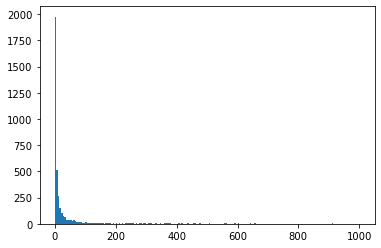

In [73]:
person_len = [intrvl.size() for intrvl in person[0].get_intervals()]
person_len[:20]
import matplotlib.pyplot as plt

plt.hist(person_len, bins=200,range=(0,1000))
plt.show()

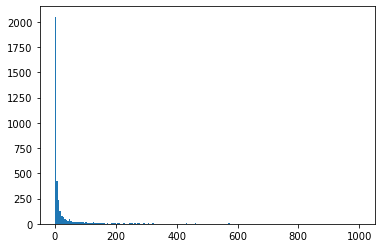

In [74]:
bikes_len = [intrvl.size() for intrvl in bikes[0].get_intervals()]
import matplotlib.pyplot as plt

plt.hist(bikes_len, bins=200,range=(0,1000))
plt.show()

In [60]:
bikes[0].get_intervals()[:10]

[<Interval t1:178.0 t2:179.0 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.4173813, 'class': True}>,
 <Interval t1:180.0 t2:183.0 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.42373562, 'class': True}>,
 <Interval t1:186.0 t2:187.0 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.4168872, 'class': True}>,
 <Interval t1:188.0 t2:243.0 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.4613846, 'class': True}>,
 <Interval t1:494.0 t2:755.0 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.44067577, 'class': True}>,
 <Interval t1:758.0 t2:787.0 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.4203353, 'class': True}>,
 <Interval t1:792.0 t2:889.0 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.4224427, 'class': True}>,
 <Interval t1:898.0 t2:1385.0 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.58789164, 'class': True}>,
 <Interval t1:1386.0 t2:1400.0 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:{'score': 0.5444755, 'class': True}>,
 <Interval t1:1401.0 t2:1403.0 x1:0.0 x2:1.0 y1:0.0 y2:1.0 payload:

In [61]:
import time
t = time.time()
person_intersect_bike = person.join(
    bikes,
    predicate = and_pred(
        Bounds3D.T(overlaps()),
        Bounds3D.X(overlaps()),
        Bounds3D.Y(overlaps())
    ),
    merge_op = lambda interval1, interval2: Interval(
        interval1['bounds'].intersect_time_span_space(interval2['bounds']),
        payload = {"person": interval1['payload'], "bike":interval2['payload']}
    ),
    window = 0.0,
    progress_bar = True
)
t = time.time() - t

100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


In [62]:
print("Time cost: ", t)
print("number of results: ", len(person_intersect_bike[0]))

Time cost:  0.26000046730041504
number of results:  5193


In [64]:
len(person_intersect_bike[0])
person_intersect_bike[0].duration()

195578.0

In [65]:
intrvl_len = [intrvl.size() for intrvl in person_intersect_bike[0].get_intervals()]
intrvl_len[:20]

[1.0,
 3.0,
 1.0,
 55.0,
 261.0,
 29.0,
 97.0,
 487.0,
 14.0,
 2.0,
 59.0,
 44.0,
 4.0,
 1.0,
 2.0,
 2.0,
 5.0,
 1.0,
 2.0,
 75.0]

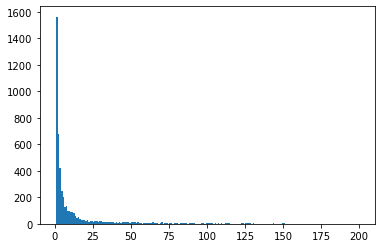

In [66]:
import matplotlib.pyplot as plt

plt.hist(intrvl_len, bins=200,range=(0,200))
plt.show()

In [ ]:
# Using alredy existed datasource
from cyclist_tutorial_helpers import *
bboxes = get_maskrcnn_bboxes()
bikes = bboxes.filter(lambda interval: interval['payload']['class'] == 'bicycle')
person = bboxes.filter(lambda interval: interval['payload']['class'] == 'person')
visualize_helper([bikes, person])

In [ ]:
import time
t = time.time()
person_intersect_bike = person.join(
    bikes,
    predicate = and_pred(
        Bounds3D.T(equal()),
        Bounds3D.X(overlaps()),
        Bounds3D.Y(overlaps())
    ),
    merge_op = lambda interval1, interval2: Interval(
        interval1['bounds'].span(interval2['bounds']),
        payload = {"person": interval1['payload'], "bike":interval2['payload']}
    ),
    window = 0.0,
    progress_bar = True
)
t = time.time() - t

In [24]:
print("Time cost: ", t)
print("number of results: ", len(person_intersect_bike[0]))

Time cost:  0.16699838638305664
number of results:  1651


In [25]:
visualize_helper([person_intersect_bike])

VGridWidget(vgrid_spec={'compressed': True, 'data': b'x\x9c\xd4\x9d\xcb\xae\xa4\xc9u\x9d_\xc5\xe0\xd8 \xe2~\xf…

In [8]:
len(person_intersect_bike[0])

1651

In [53]:
person_intersect_bike[0].get_intervals()[:10]

[<Interval t1:65.1 t2:65.2 x1:0.5132896435625504 x2:0.518877800344077 y1:0.3066855672200521 y2:0.3597064615885417 payload:{'person': {'class': 'person', 'score': 0.9436255097389221, 'spatial_type': <vgrid.spatial_type.SpatialType_Bbox object at 0x000002A431E8E0D0>}, 'bike': {'class': 'bicycle', 'score': 0.759299635887146, 'spatial_type': <vgrid.spatial_type.SpatialType_Bbox object at 0x000002A431E8EAF0>}}>,
 <Interval t1:67.6 t2:67.7 x1:0.5057249698853915 x2:0.5159842326829207 y1:0.3005811360677083 y2:0.36616178385416664 payload:{'person': {'class': 'person', 'score': 0.9106865525245667, 'spatial_type': <vgrid.spatial_type.SpatialType_Bbox object at 0x000002A431EDF1F0>}, 'bike': {'class': 'bicycle', 'score': 0.7944093942642212, 'spatial_type': <vgrid.spatial_type.SpatialType_Bbox object at 0x000002A431EDF670>}}>,
 <Interval t1:67.7 t2:67.8 x1:0.5045224003937702 x2:0.5155925658589976 y1:0.3002436116536458 y2:0.36624593098958336 payload:{'person': {'class': 'person', 'score': 0.806196749

In [60]:
segments = []
cur_seg = None
for cur_frame in person_intersect_bike[0].get_intervals():
    if cur_seg == None:
        cur_seg = [cur_frame]
    else:
        last_frame = cur_seg[-1]
        if abs(cur_frame['t1'] - last_frame['t2']) <= 0.1:
            cur_seg.append(cur_frame)
        else:
            segments.append(cur_seg)
            cur_seg = None

len(segments)

242

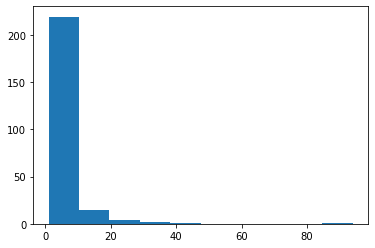

In [61]:
import matplotlib.pyplot as plt
seglen = sorted([len(seg) for seg in segments])
plt.hist(seglen )
plt.show()